# 00 — Setup and Data Preparation (Tabla Taala Dataset)

This notebook installs dependencies, downloads the Kaggle dataset `pranav6670/tabla-taala-dataset` using KaggleHub, validates its contents, and prepares stratified train/val/test CSV splits under the project `data/processed/` area. It also creates a dedicated project folder for the dataset under `data/external/tabla_taala/`.

Notes:

- Uses kagglehub for idempotent downloads.
- Prefer symlinks to avoid dataset duplication; falls back to copy when symlinks are not supported.
- Project convention: pure `keras` imports (not `tensorflow.keras`).


In [11]:
# 1) Install and Import Dependencies
import sys, subprocess

def ensure(pkg):
    try:
        __import__(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for pkg in ['kagglehub', 'pandas', 'librosa', 'soundfile']:
    ensure(pkg)

import kagglehub
import pandas as pd
import numpy as np
import os, json, shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Audio, display

print('Dependencies ready.')

Dependencies ready.


In [12]:
# 2) Configure Base Paths and Create Folders
NB_DIR = Path.cwd()
BASE_DIR = NB_DIR.parents[1]  # project root
DATA_DIR = BASE_DIR / 'data'
RAW_DIR = DATA_DIR / 'raw'
EXTERNAL_DIR = DATA_DIR / 'external'
PROCESSED_DIR = DATA_DIR / 'processed_tabla'

DATASET_EXT_DIR = EXTERNAL_DIR / 'tabla_taala'

for p in [DATA_DIR, RAW_DIR, EXTERNAL_DIR, PROCESSED_DIR, DATASET_EXT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print('Project paths:')
print('BASE_DIR=', BASE_DIR)
print('DATA_DIR=', DATA_DIR)
print('EXTERNAL_DIR=', EXTERNAL_DIR)
print('PROCESSED_DIR=', PROCESSED_DIR)
print('DATASET_EXT_DIR=', DATASET_EXT_DIR)

Project paths:
BASE_DIR= /home/alepot55/Desktop/projects/naml_project
DATA_DIR= /home/alepot55/Desktop/projects/naml_project/data
EXTERNAL_DIR= /home/alepot55/Desktop/projects/naml_project/data/external
PROCESSED_DIR= /home/alepot55/Desktop/projects/naml_project/data/processed_tabla
DATASET_EXT_DIR= /home/alepot55/Desktop/projects/naml_project/data/external/tabla_taala


In [13]:
# 3) Download Dataset via kagglehub
DATASET_ID = 'pranav6670/tabla-taala-dataset'
try:
    dl_path = kagglehub.dataset_download(DATASET_ID)
    print('KaggleHub path:', dl_path)
    assert Path(dl_path).exists(), 'Download path does not exist after kagglehub call.'
except Exception as e:
    print('Download failed:', e)
    print('Tip: ensure kagglehub is installed and that your network allows downloads. Try rerunning this cell.')

KaggleHub path: /home/alepot55/.cache/kagglehub/datasets/pranav6670/tabla-taala-dataset/versions/5


In [14]:
# 4) Verify Download and Inspect Directory Tree
from pathlib import Path
import os

root = Path(dl_path)
print('Top-level entries:')
for p in sorted(root.iterdir()):
    print(' -', p.name, '(dir)' if p.is_dir() else '(file)')

# Count files recursively and compute total size
n_files = 0
n_bytes = 0
for dirpath, dirnames, filenames in os.walk(root):
    for f in filenames:
        n_files += 1
        try:
            n_bytes += (Path(dirpath)/f).stat().st_size
        except Exception:
            pass
size_mb = n_bytes / (1024*1024)
print(f'Total files: {n_files} | Approx size: {size_mb:.1f} MB')

# Expect these to exist
assert (root/'wavfiles').exists(), 'Expected folder wavfiles not found.'
assert (root/'file_name.csv').exists(), 'Expected CSV file_name.csv not found.'
print('Verified wavfiles/ and file_name.csv presence.')

Top-level entries:
 - file_name.csv (file)
 - tablaDataset (dir)
 - wavfiles (dir)
Total files: 1123 | Approx size: 1095.4 MB
Verified wavfiles/ and file_name.csv presence.


In [15]:
# 5) Add/Sync Dataset into Project Folder (copy or symlink)
import platform
src_root = Path(dl_path)
dst_root = DATASET_EXT_DIR

# Choose strategy: symlink if possible to avoid duplication
strategy = 'symlink'
try:
    if dst_root.exists() and dst_root.is_symlink():
        dst_root.unlink()
    if dst_root.exists() and not any(dst_root.iterdir()):
        pass
    if not dst_root.exists():
        dst_root.symlink_to(src_root, target_is_directory=True)
    print('Symlinked dataset into', dst_root)
except Exception as e:
    print('Symlink not supported, falling back to copy:', e)
    if dst_root.exists():
        print('Destination exists, skipping copy.')
    else:
        shutil.copytree(src_root, dst_root)
        print('Copied dataset into', dst_root)

Symlinked dataset into /home/alepot55/Desktop/projects/naml_project/data/external/tabla_taala


In [16]:
# 6) Load file_name.csv and Explore Labels
csv_path = Path(dl_path) / 'file_name.csv'
df = pd.read_csv(csv_path)
print('CSV shape:', df.shape)
print(df.head())

# Basic hygiene checks
df = df.rename(columns={c: c.strip() for c in df.columns})
assert 'fname' in df.columns and 'label' in df.columns, 'Expected columns fname and label in CSV.'
print('Label distribution (counts):')
print(df['label'].value_counts())
print('Label distribution (fraction):')
print((df['label'].value_counts(normalize=True) * 100).round(2).astype(str) + '%')

# Duplicates / missing
dups = df['fname'].duplicated().sum()
na_rows = df.isna().sum()
print('Duplicate fname entries:', dups)
print('Missing values per column:\n', na_rows)

CSV shape: (561, 2)
               fname        label
0  addhatrital01.wav  Addhatrital
1  addhatrital02.wav  Addhatrital
2  addhatrital03.wav  Addhatrital
3  addhatrital04.wav  Addhatrital
4  addhatrital05.wav  Addhatrital
Label distribution (counts):
label
Trital         99
Addhatrital    78
Dadra          72
Bhajani        72
Deepchandi     60
Ektal          60
Jhaptal        60
Rupak          60
Name: count, dtype: int64
Label distribution (fraction):
label
Trital         17.65%
Addhatrital     13.9%
Dadra          12.83%
Bhajani        12.83%
Deepchandi      10.7%
Ektal           10.7%
Jhaptal         10.7%
Rupak           10.7%
Name: proportion, dtype: object
Duplicate fname entries: 0
Missing values per column:
 fname    0
label    0
dtype: int64


In [17]:
# 7) Resolve Audio File Paths from CSV
wav_dir = Path(dl_path) / 'wavfiles'

# Determine the filename column robustly
candidate_cols = ['fname', 'filename', 'file_name', 'file', 'wav_file', 'audio', 'path']
name_col = next((c for c in candidate_cols if c in df.columns), None)
if name_col is None:
    raise KeyError(f'None of the expected filename columns found. Available columns: {list(df.columns)}')

# Build lookup maps (exact name and stem-only) for fast resolution
all_files = [p for p in wav_dir.rglob('*') if p.is_file()]
name_map = {p.name.lower(): p for p in all_files}
stem_map = {p.stem.lower(): p for p in all_files if p.suffix}

def resolve_path(raw_name: str) -> Path:
    """Resolve an audio file path from a raw CSV name against wav_dir.

    The function attempts, in order: exact filename match (case-insensitive),
    stem-only match (CSV without extension or mismatched extension), and a
    direct join with wav_dir. Returns a Path if found, else None.

    Args:
        raw_name: The raw filename string from the CSV.

    Returns:
        pathlib.Path or None: The resolved file path if found.
    """
    key = str(raw_name).strip()
    p = name_map.get(key.lower())
    if p is None:
        stem = Path(key).stem.lower()
        p = stem_map.get(stem)
    if p is None:
        candidate = wav_dir / key
        p = candidate if candidate.exists() else None
    return p

resolved_paths = [resolve_path(v) for v in df[name_col].astype(str).tolist()]

missing_mask = [p is None or not Path(p).exists() for p in resolved_paths]
missing = int(np.sum(missing_mask))
if missing > 0:
    print(f'Missing {missing} files referenced by CSV; they will be dropped.')

# Normalize columns
df = df.copy()
df['fname'] = df[name_col].astype(str)
df['audio_path'] = [str(p) if p is not None else None for p in resolved_paths]

# Keep only rows with resolvable audio
before = len(df)
df = df[~pd.isna(df['audio_path'])].reset_index(drop=True)
print('After resolving paths, kept rows:', len(df), '| dropped:', before - len(df))

After resolving paths, kept rows: 561 | dropped: 0


fname                                              trital51.wav
label                                                    Trital
audio_path    /home/alepot55/.cache/kagglehub/datasets/prana...
Name: 513, dtype: object

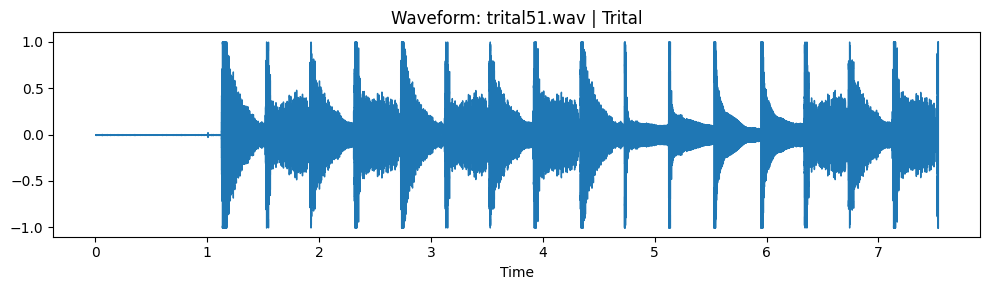

In [18]:
# 8) Quick Audio Preview (waveform + listen)
import random
import IPython.display as ipd
import librosa.display

RANDOM_STATE = 42

# Determine the label column robustly
label_candidates = ['label', 'class', 'genre', 'taala', 'taal', 'label_name']
label_col = next((c for c in label_candidates if c in df.columns), None)
if label_col is None:
    raise KeyError(f'None of the expected label columns found. Available columns: {list(df.columns)}')

if len(df) > 0:
    sample_row = df.sample(1, random_state=RANDOM_STATE).iloc[0]
    ipd.display(sample_row[['fname', label_col, 'audio_path']])
    # Load audio at native sampling rate to avoid relying on an undefined SR
    y, sr = librosa.load(sample_row['audio_path'], sr=None)
    plt.figure(figsize=(10,3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {sample_row['fname']} | {sample_row[label_col]}")
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(y, rate=sr))
else:
    print('No rows available to preview.')

In [19]:
# 9) Stratified Train/Val/Test Splits and Save CSVs
from sklearn.model_selection import train_test_split

assert 'label' in df.columns and 'audio_path' in df.columns, 'Required columns missing.'

# Basic hygiene: drop duplicates by audio path
before = len(df)
df = df.drop_duplicates(subset=['audio_path']).reset_index(drop=True)
print(f'Dropped {before - len(df)} duplicate rows by audio_path')

# Encode labels for stratification
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['y'] = le.fit_transform(df['label'].astype(str))

# 80/10/10 split with stratification
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df['y'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_df['y'])

print('Split sizes ->', 'train:', len(train_df), 'val:', len(val_df), 'test:', len(test_df))

# Save CSVs under processed folder
processed_dir = PROCESSED_DIR
processed_dir.mkdir(parents=True, exist_ok=True)

train_csv = processed_dir / 'train_split.csv'
val_csv = processed_dir / 'val_split.csv'
test_csv = processed_dir / 'test_split.csv'

cols = ['audio_path', 'label', 'fname']
train_df[cols].to_csv(train_csv, index=False)
val_df[cols].to_csv(val_csv, index=False)
test_df[cols].to_csv(test_csv, index=False)

# Save label encoder mapping for reproducibility
import json
classes = list(le.classes_)
with open(processed_dir / 'label_encoder.json', 'w') as f:
    json.dump({'classes': classes}, f, indent=2)

print('Saved splits to:', processed_dir)
print('Classes:', classes)

Dropped 0 duplicate rows by audio_path
Split sizes -> train: 448 val: 56 test: 57
Saved splits to: /home/alepot55/Desktop/projects/naml_project/data/processed_tabla
Classes: ['Addhatrital', 'Bhajani', 'Dadra', 'Deepchandi', 'Ektal', 'Jhaptal', 'Rupak', 'Trital']
Split sizes -> train: 448 val: 56 test: 57
Saved splits to: /home/alepot55/Desktop/projects/naml_project/data/processed_tabla
Classes: ['Addhatrital', 'Bhajani', 'Dadra', 'Deepchandi', 'Ektal', 'Jhaptal', 'Rupak', 'Trital']


In [20]:
# 11) Compute and save mel-spectrogram arrays (X_train/val/test.npy, y_*.npy) with leak-free scaling
import numpy as np
import librosa
import pickle
from pathlib import Path
from tqdm import tqdm

# Config aligned with training notebook
SR = 22050
DURATION = 3.0
N_FFT = 1024
HOP = 512
N_MELS = 128
TARGET_FRAMES = 130  # align with GTZAN/FMA default input time steps

def load_mono_slice(path: str, sr: int = SR, duration: float = DURATION) -> np.ndarray:
    """Load audio file as mono float32 of exact duration (pad or crop)."""
    target_len = int(sr * duration)
    y, _sr = librosa.load(path, sr=sr, mono=True)
    if y.shape[0] < target_len:
        y = np.pad(y, (0, target_len - y.shape[0]))
    elif y.shape[0] > target_len:
        y = y[:target_len]
    return y.astype(np.float32)

def compute_logmel(y: np.ndarray, sr: int = SR) -> np.ndarray:
    """Return log-mel spectrogram (N_MELS x T) as float32."""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, power=2.0)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

def pad_or_crop_time(mel: np.ndarray, T: int = TARGET_FRAMES) -> np.ndarray:
    """Pad or crop time axis to T frames."""
    cur_T = mel.shape[1]
    if cur_T < T:
        pad_width = T - cur_T
        mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=0.0)
    elif cur_T > T:
        mel = mel[:, :T]
    return mel

label2idx = {c: i for i, c in enumerate(classes)}

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

splits = {
    'train': train_df,
    'val':   val_df,
    'test':  test_df,
}

X = {}
Y = {}

print('Computing log-mel arrays (this may take a few minutes)...')
for split_name, df in splits.items():
    x_list = []
    y_list = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing {split_name}'):
        path = str(row['audio_path'])
        label = str(row['label']).strip()
        if label not in label2idx:
            raise ValueError(f'Unknown label {label} found in {split_name} split')
        y = load_mono_slice(path)
        mel = compute_logmel(y)
        mel = pad_or_crop_time(mel)
        x_list.append(mel)
        y_list.append(label2idx[label])
    X[split_name] = np.stack(x_list, axis=0)  # (N, M, T)
    Y[split_name] = np.asarray(y_list, dtype=np.int64)
    print(split_name, 'shape:', X[split_name].shape, '| labels:', Y[split_name].shape)

# Fit leak-free scaler on training set (per-mel mean/std over samples and time)
train_mels = X['train']  # (N, M, T)
mean_per_mel = train_mels.mean(axis=(0, 2), dtype=np.float64).astype(np.float32)  # (M,)
std_per_mel = train_mels.std(axis=(0, 2), dtype=np.float64).astype(np.float32)
std_per_mel = np.where(std_per_mel < 1e-6, 1e-6, std_per_mel)

# Apply scaling
for k in ['train', 'val', 'test']:
    X[k] = (X[k] - mean_per_mel[None, :, None]) / std_per_mel[None, :, None]

# Save arrays
np.save(PROCESSED_DIR / 'X_train.npy', X['train'])
np.save(PROCESSED_DIR / 'y_train.npy', Y['train'])
np.save(PROCESSED_DIR / 'X_val.npy',   X['val'])
np.save(PROCESSED_DIR / 'y_val.npy',   Y['val'])
np.save(PROCESSED_DIR / 'X_test.npy',  X['test'])
np.save(PROCESSED_DIR / 'y_test.npy',  Y['test'])

# Save scaler for reproducibility
scaler_info = {
    'mean_per_mel': mean_per_mel,
    'std_per_mel': std_per_mel,
    'sr': SR,
    'n_fft': N_FFT,
    'hop_length': HOP,
    'n_mels': N_MELS,
    'target_frames': TARGET_FRAMES,
}
with open(PROCESSED_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler_info, f)

print('Saved arrays and scaler to:', str(PROCESSED_DIR))

Computing log-mel arrays (this may take a few minutes)...


Processing train: 100%|██████████| 448/448 [00:03<00:00, 113.88it/s]


train shape: (448, 128, 130) | labels: (448,)


Processing val: 100%|██████████| 56/56 [00:00<00:00, 98.08it/s]


val shape: (56, 128, 130) | labels: (56,)


Processing test: 100%|██████████| 57/57 [00:00<00:00, 80.37it/s]



test shape: (57, 128, 130) | labels: (57,)
Saved arrays and scaler to: /home/alepot55/Desktop/projects/naml_project/data/processed_tabla
